example showing simulation and optimisation of a single element spherical collimation lens

In [1]:
import sys
sys.path.append("..")

import jax
jax.config.update("jax_enable_x64", True)

from jax_optics.surface import Sphere, Plane, Circle
from jax_optics.interaction import Refract, Stop
from jax_optics.trace import trace
from jax_optics.plot import plot_rays, plot_surface
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxopt

## the model

In [2]:
r = 50.0
t = 4.5
ri = 1.49

# calculate initial parameters using the lensmaker's equation
f_inv = (ri - 1) * (1 / (r - (t * (ri - 1)) / ri) + 1 / r)
f = 1.0 / f_inv
params0 = jnp.array([f, t, r, -r])

shape = Circle(12.0)

def make_surfaces(distance, thickness, r1, r2):
    return [
        (Sphere(r1, shape).translate(distance), Refract(1.0, ri)),
        (Sphere(r2, shape).translate(distance + thickness), Refract(ri, 1.0)),
        (Plane(shape).translate(100.0), Stop()),
    ]

## ray-tracing

In [3]:
def trace_angle(surfaces, angle_deg):
    angle = jnp.radians(angle_deg)
    pos = jnp.zeros(3)
    dir = jnp.array([jnp.cos(angle), jnp.sin(angle), 0.0])
    return trace(pos, dir, surfaces)
    
trace_angles = jax.jit(jax.vmap(trace_angle, in_axes=(None, 0)))
angles = jnp.linspace(-10, 10, 20)

In [4]:
surfaces = make_surfaces(*params0)
poss, dirs = trace_angles(surfaces, angles)

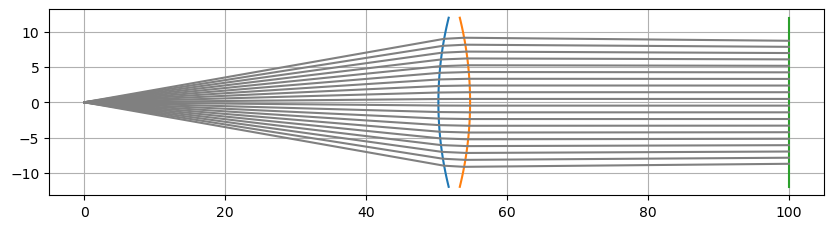

In [5]:
plt.rcParams["figure.figsize"] = (10, 6)
for surface, interaction in surfaces:
    plot_surface(surface)
plot_rays(poss, c="grey")
plt.gca().set_aspect(1)
plt.grid()

## optimisation

In [6]:
def evaluate(poss, dirs):
    angle_error = jnp.sum(dirs[:, -1, 1] * dirs[:, -1, 1])

    size = poss[-1, -1, 1]
    size_target = 10.0
    size_error = (size - size_target) * (size - size_target)

    return angle_error + size_error * 0.01


@jax.jit
def objective(params, angles):
    surfaces = make_surfaces(*params)
    poss, dirs = trace_angles(surfaces, angles)

    return evaluate(poss, dirs)


bounds = [(10.0, 70.0), (3.0, 20.0), (-300, 300), (-300, 300)]
bounds_j = (
    jnp.array([lb for (lb, ub) in bounds]),
    jnp.array([ub for (lb, ub) in bounds]),
)

solver = jaxopt.ScipyBoundedMinimize(
    method="l-bfgs-b", fun=objective, maxiter=500, tol=1e-15
)

opt_params, opt_state = solver.run(params0, bounds=bounds_j, angles=angles)
print("success", opt_state.success)
print("initial objective", objective(params0, angles))
print("final objective", objective(opt_params, angles))

success True
initial objective 0.016469065639337015
final objective 1.714604177738176e-05


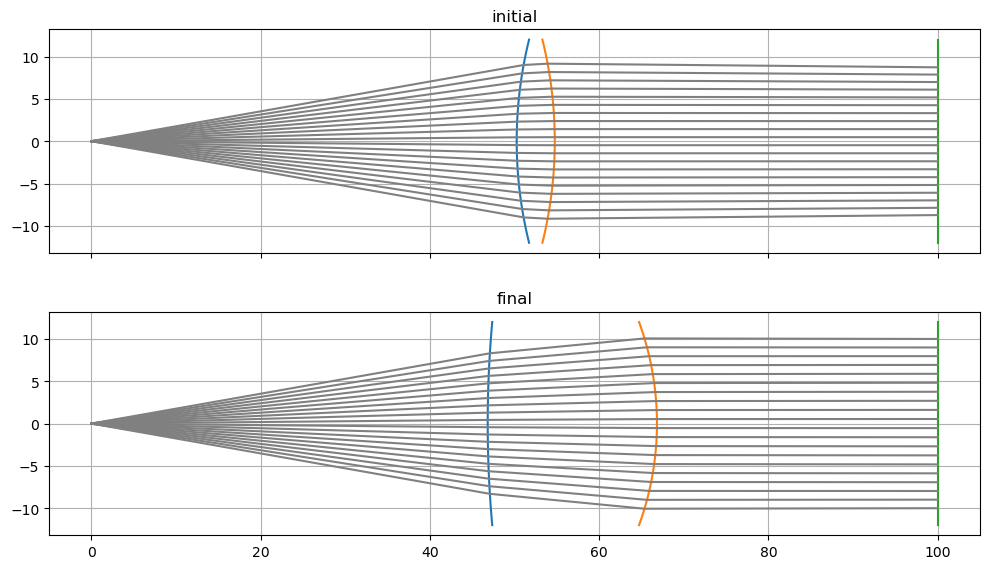

In [7]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

for name, ax, params in ("initial", ax1, params0), ("final", ax2, opt_params):
    surfaces = make_surfaces(*params)
    poss, dirs = trace_angles(surfaces, angles)

    for surface, interaction in surfaces:
        plot_surface(surface, ax=ax)
    plot_rays(poss, c="grey", ax=ax)

    ax.set_title(name)
    ax.grid(); ax.set_aspect(1)
fig.set_tight_layout(True)